In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import librosa
from librosa import display
import IPython.display as ipd
audio_dir='/content/drive/MyDrive/Colab Notebooks/Audio/'
sr =22050

#Creating Dataset

In [ ]:
def get_filename(dir_name):
  filenames_list=[]
  for entry in os.scandir(dir_name):
     if (entry.path.endswith(".wav") and entry.is_file()):
      filenames_list.append(entry.name)
  return filenames_list

def get_subfolders(dir_name):
  dirlist=[]
  for item in os.listdir(dir_name):
    if os.path.isdir(item):
        dirlist.append(item)
  return dirlist

def Audio_to_tensor(dir_name):
  os.chdir(dir_name)
  print(dir_name)
  X=[]
  folder_list=get_subfolders(dir_name)
  avance=1
  for folder in folder_list:
    print("Treating folder",avance,"out of",np.size(folder_list))
    avance=avance+1
    filename_list=get_filename(dir_name+'/'+folder)
    os.chdir(dir_name+'/'+folder)
    for file in filename_list:
      S,sf=librosa.load(dir_name+'/'+folder+'/'+file)
      sf=librosa.stft(S)
      X.append(sf)
  X=np.array(X)
  tensor=tf.convert_to_tensor(X,dtype=tf.complex64)
  print("Done !")
  return tensor

In [ ]:
X=Audio_to_tensor(audio_dir+'X_train')
y=Audio_to_tensor(audio_dir+'y_train')
X_valid=Audio_to_tensor(audio_dir+'X_valid')
y_valid=Audio_to_tensor(audio_dir+'y_valid')

/content/drive/MyDrive/Colab Notebooks/Audio/X_train
Treating folder 1 out of 4
Treating folder 2 out of 4
Treating folder 3 out of 4
Treating folder 4 out of 4
Done !
/content/drive/MyDrive/Colab Notebooks/Audio/y_train
Treating folder 1 out of 4
Treating folder 2 out of 4
Treating folder 3 out of 4
Treating folder 4 out of 4
Done !
/content/drive/MyDrive/Colab Notebooks/Audio/X_valid
Treating folder 1 out of 1
Done !
/content/drive/MyDrive/Colab Notebooks/Audio/y_valid
Treating folder 1 out of 1
Done !


In [ ]:
input_shape = X.shape[1:]

print("Input shape: {}".format(input_shape))

Input shape: (1025, 9)


#CNN

## Configuration of our CNN

In [140]:
from tensorflow.keras import callbacks
early_stopping=callbacks.EarlyStopping(
    patience=5,
    min_delta=0.0001,
    restore_best_weights=True
)

In [141]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
        layers.BatchNormalization(input_shape=input_shape),          
        layers.Conv1D(9, 3,padding="same",activation='relu',input_shape=input_shape),
        layers.Dense(units=9)
        #tf.keras.layers.MaxPooling1D(pool_size=2, padding='valid'),
        ])
model.compile(
    optimizer = 'Adam',
    loss = 'mae',)
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_16 (Batc (None, 1025, 9)           36        
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1025, 9)           252       
_________________________________________________________________
dense_16 (Dense)             (None, 1025, 9)           90        
Total params: 378
Trainable params: 360
Non-trainable params: 18
_________________________________________________________________


## Training of our model

Minimum Validation Loss: 0.0270


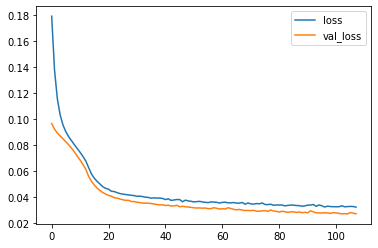

In [142]:
history = model.fit(
    X, y,
    validation_data=(X_valid,y_valid),
    #batch_size=256,
    epochs=1500,
    callbacks=[early_stopping],
    verbose=False
)
# Start the plot at epoch 10
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

##Results

We tried to make a prediction using our validation data. This works very well but it could be related to the fact that our validation data is very close to our training data.

In [143]:
y_predict=model.predict(X_valid)

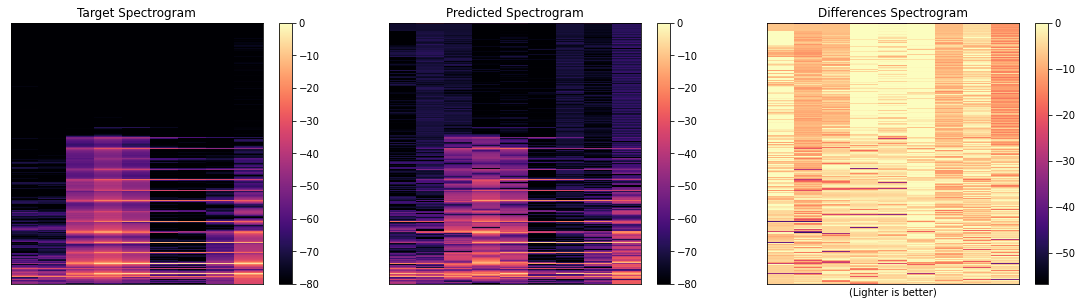

In [144]:
S_db_pred = librosa.amplitude_to_db(np.abs(y_predict[120]), ref=np.max)
S_db_tar = librosa.amplitude_to_db(np.abs(y_valid.numpy()[120]), ref=np.max)
S_db_diff = librosa.amplitude_to_db(np.abs(diff), ref=np.max)
diff=np.empty_like(S_db_pred)
for i in range(S_db_pred.shape[0]):
  for j in range(S_db_pred.shape[1]):
    diff[i,j]=-abs((S_db_pred[i,j]-S_db_tar[i,j]))

plt.figure(figsize=[3*6.4,4.8])
plt.subplot(1,3,1)
librosa.display.specshow(S_db_tar)
plt.colorbar()
plt.title("Target Spectrogram")
plt.subplot(1,3,2)
librosa.display.specshow(S_db_pred)
plt.title("Predicted Spectrogram")
plt.colorbar()
plt.subplot(1,3,3)
ax=librosa.display.specshow(diff)
plt.title("Differences Spectrogram")
plt.xlabel("(Lighter is better)")
plt.colorbar()

In [145]:
predicted_audio=[]
for sample in range(y_predict.shape[0]):
  predicted_audio=np.append(predicted_audio,librosa.istft(y_predict[sample]))
target_audio=[]
for sample in range(y_valid.shape[0]):
  target_audio=np.append(target_audio,librosa.istft(y_valid.numpy()[sample]))
  

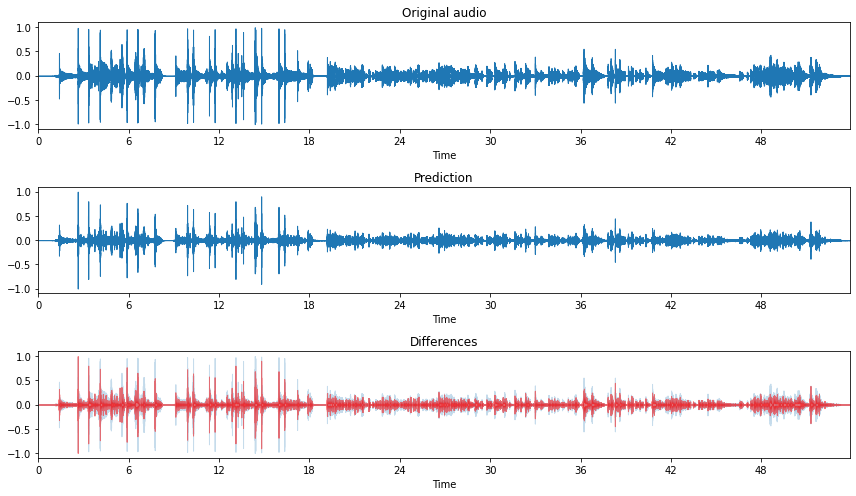

In [146]:
predicted_audio=librosa.util.normalize(predicted_audio)
target_audio=librosa.util.normalize(target_audio)
plt.figure(figsize=[12,7])
plt.subplot(3,1,1)
librosa.display.waveplot(target_audio,sr=22050)
plt.title("Original audio")
plt.subplot(3,1,2)
librosa.display.waveplot(predicted_audio,sr=22050)
plt.title("Prediction")
plt.subplot(3,1,3)
librosa.display.waveplot(target_audio,sr=22050,alpha=0.25)
librosa.display.waveplot(predicted_audio,sr=22050,alpha=0.5,color='r')
plt.title("Differences")
plt.tight_layout()

In [147]:
ipd.Audio(target_audio,rate=22050)

In [148]:
ipd.Audio(predicted_audio,rate=22050,)